In [19]:
import datasets
import peft
import pickle
import pytest, ipytest
import transformers

from datasets import(
    load_dataset, 
    load_dataset_builder,
    get_dataset_split_names,
    get_dataset_config_names,
)

from peft import(
    LoftQConfig,
    LoraConfig,
    get_peft_model,
)

from transformers import(
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from trl import SFTTrainer, SFTConfig
# allows fast processing of datasets

In [2]:
%run LoRA_Training/training_functions.ipynb

## Imported Functions
1. model_from_pkl(model): extracts ML model from pkl file
2. map_data(data, model, tokenizer): performs preprocessing/tokenization on data
3. make_trainer(m_model, train_data, test_data, config, args): creates training object with model, training arguments, train/test data, a configuration, and evaluation function
4. compute_metrics(eval_pred): used in the trainer, calculates prediction accuracy/validation loss
5. get_training_output(trainer, keys: list): extracts data from training logs
6. get_dataframe(training_output: list, strategy): used in get_training_output, puts training data into dataframe/graph form

In [3]:
ds_builder1=load_dataset_builder("LongSafari/open-genome", "stage1")
print(ds_builder1.info.features)
ds_builder2=load_dataset_builder("LongSafari/open-genome", "stage2")
print(ds_builder2.info.features)
ds_builder3=load_dataset_builder("LongSafari/open-genome", "sample")
print(ds_builder3.info.features)

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}


In [4]:
ds_gs=load_dataset("LongSafari/open-genome", "sample")
get_dataset_split_names("LongSafari/open-genome", "sample")

['validation']

In [5]:
ds_gst1_train=load_dataset("LongSafari/open-genome", "stage1", split="train[:500]")
#print(ds_gst1[50])
ds_gst1_test=load_dataset("LongSafari/open-genome", "stage1", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage1"))
ds_gst2_train=load_dataset("LongSafari/open-genome", "stage2", split="train[:500]")
ds_gst2_test=load_dataset("LongSafari/open-genome", "stage2", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage2"))

['train', 'validation', 'test']
['train', 'validation', 'test']


In [6]:
lla_321, lla_321_tokenizer=model_from_pkl("Llama-3.2-1B")

In [7]:
lla_323, lla_323_tokenizer=model_from_pkl("Llama-3.2-3B")

In [8]:
l_tokenized_genome_samples=map_data(ds_gs, lla_321, lla_321_tokenizer)

In [9]:
l_tokenized_stage1_train=map_data(ds_gst1_train, lla_321, lla_321_tokenizer)
l_tokenized_stage1_test=map_data(ds_gst1_test, lla_321, lla_321_tokenizer)

In [10]:
l_tokenized_stage2_train=map_data(ds_gst2_train, lla_321, lla_321_tokenizer)
l_tokenized_stage2_test=map_data(ds_gst2_test, lla_321, lla_321_tokenizer)

In [11]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [12]:
lla_lora_model=get_peft_model(lla_321, config)
print_trainable_parameters(lla_lora_model)

trainable params: 851968 || all params: 1236666368 || trainable%: 0.07


In [13]:
l_trainer=make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps",
                                    logging_steps=2))

In [14]:
l_trainer.train() #same arguments as m_trainer

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.645500,2.586089,0.000449
2,0.647300,2.582593,0.000449
3,0.651900,2.581360,0.000391


IOStream.flush timed out
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
IOStream.flush timed out
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=48, training_loss=0.6495832776029905, metrics={'train_runtime': 1118.7164, 'train_samples_per_second': 1.341, 'train_steps_per_second': 0.043, 'total_flos': 8976366305280000.0, 'train_loss': 0.6495832776029905})

,loss,eval_loss,eval_accuracy
epoch,,,
1.0,0.6455,2.586089,0.000449
2.0,0.6473,2.582593,0.000449
3.0,0.6519,2.581360,0.000391


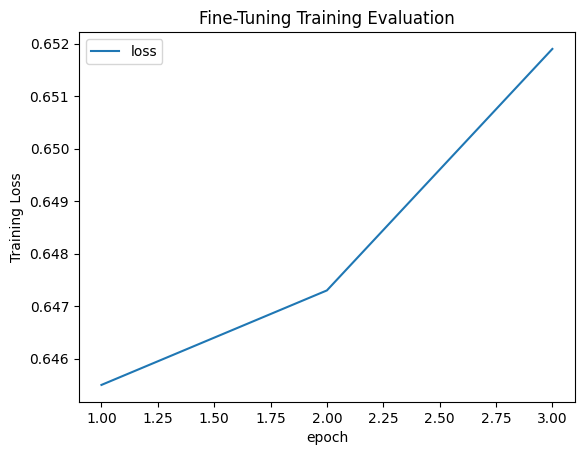

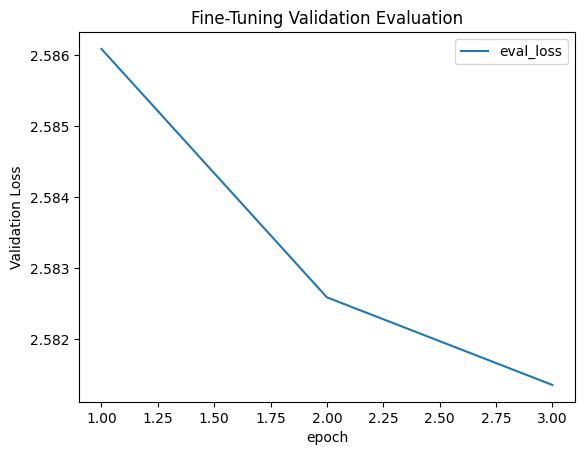

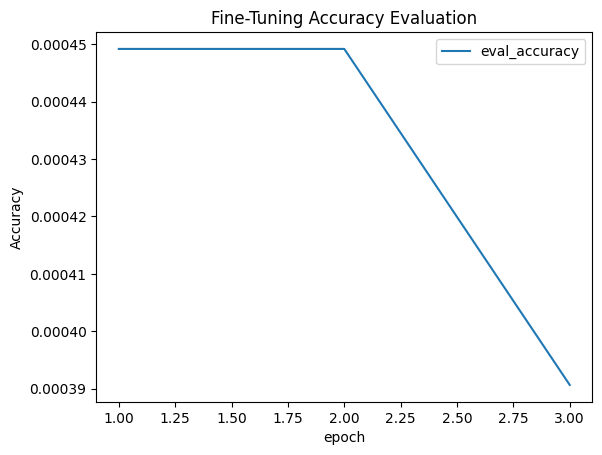

In [15]:
output=get_training_output(l_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [16]:
l2_trainer = make_trainer(lla_lora_model, l_tokenized_stage1_train, l_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps",
                                    logging_steps=6))

In [17]:
l2_trainer.train() 

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
6,0.647300,2.578625,0.000371
12,0.649600,2.576405,0.000410
18,0.644800,2.574979,0.000273
24,0.648400,2.573955,0.000332
30,0.648300,2.573056,0.000313
36,0.646700,2.572290,0.000254
42,0.645100,2.572179,0.000273
48,0.648200,2.571965,0.000234


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch

TrainOutput(global_step=48, training_loss=0.6472818454106649, metrics={'train_runtime': 2858.3146, 'train_samples_per_second': 0.525, 'train_steps_per_second': 0.017, 'total_flos': 8976366305280000.0, 'train_loss': 0.6472818454106649})

,loss,eval_loss,eval_accuracy
steps,,,
6,0.6473,2.578625,0.000371
12,0.6496,2.576405,0.000410
18,0.6448,2.574979,0.000273
24,0.6484,2.573955,0.000332
30,0.6483,2.573056,0.000313
36,0.6467,2.572290,0.000254
42,0.6451,2.572179,0.000273
48,0.6482,2.571965,0.000234


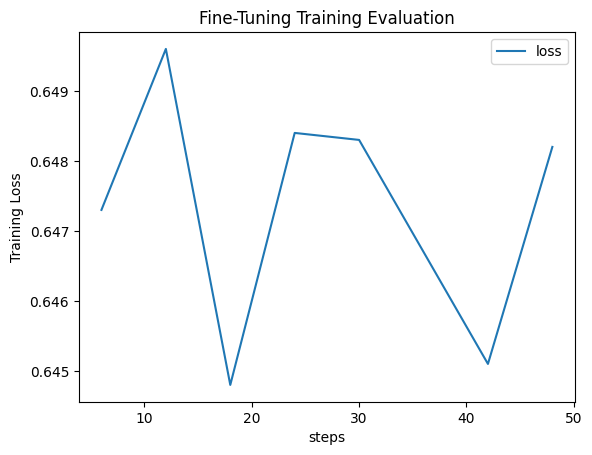

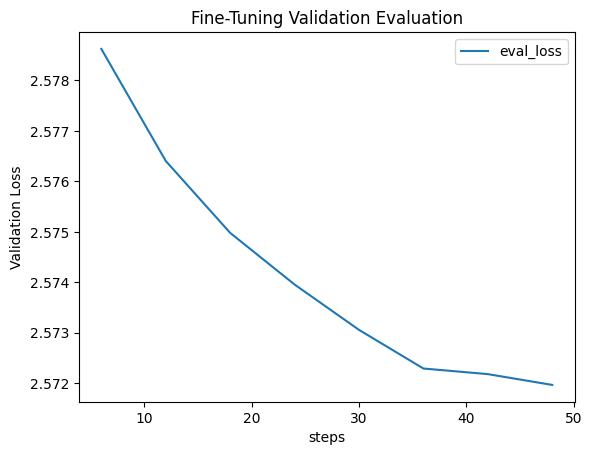

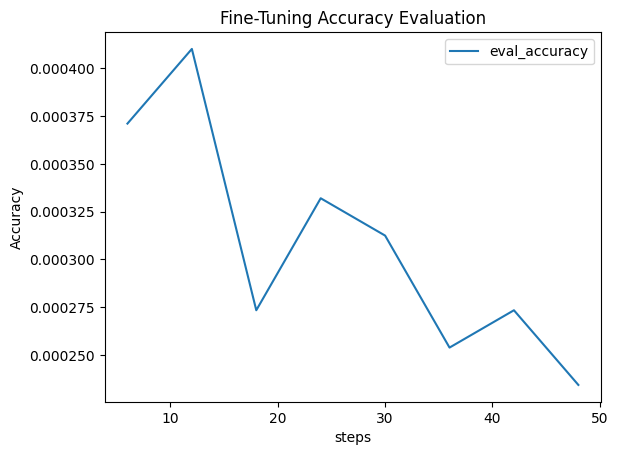

In [18]:
output=get_training_output(l2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [ ]:
l_trainer.model.save_pretrained('./fine_tuned_lla/')
l2_trainer.model.save_pretrained('./fine_tuned_lla2/')